# Python Implementation of ARMA Mixtures for Clustering

#### Paper Reference : Xiong, Yimin, and Dit-Yan Yeung. "Time series clustering with ARMA mixtures." Pattern Recognition 37.8 (2004): 1675-1689. <br>

### *Time Series Analysis (MTH 517) Course Project* <br>

Team Members - <br>

1. Hunar Preet, 160301

2. Mayank Anupam, 160388

3. Ritesh Kumar, 160575

4. Suryateja BV, 160729

Instructor: Prof. Amit Mitra

Code can also be found on https://github.com/suryabulusu/ARMA_mixtures

***********

In [376]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import statsmodels.api as sm

np.random.seed(123)

******************
### Code to simulate ARMA(2,1) process with burn-in of 200 points

In [377]:
def arma_21(params, n):
    ar1, ar2, ma1, sig = params
    
    e = []
    x = []
    
    e_init_0 = np.random.normal(0, sig)
    e.append(e_init_0)
    e_init_1 = np.random.normal(0, sig)
    e.append(e_init_1)
    
    x.append(0)
    x.append(0)
    
    burnin = 200
    
    for i in range(2, n+burnin):
        e.append(np.random.normal(0, sig))
        x.append(ar1*x[i-1] + ar2*x[i-2] + ma1*e[i-1] + e[i])
        
    return x[burnin:], e[burnin:]

### Generate 300 points and check the correctness of code by fitting statsmodels ARMA process

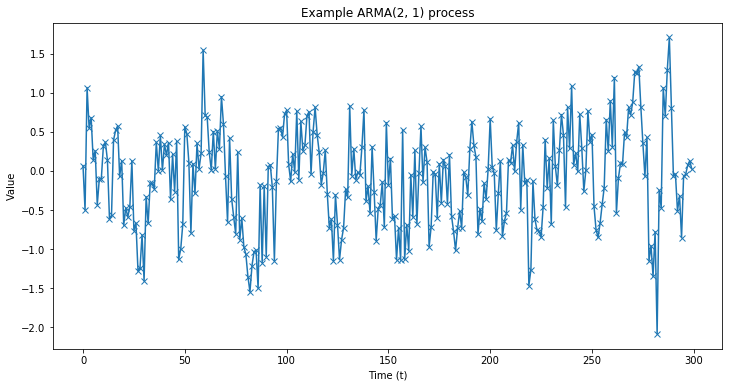

In [378]:
sig = np.sqrt(0.27) # std dev of Gaussian Noise
x, e = arma_21((-0.05, 0.52, 0.44, sig), 300)
plt.figure(figsize = (12, 6))
plt.plot(x, "-x")
plt.xlabel("Time (t)")
plt.ylabel("Value")
plt.title("Example ARMA(2, 1) process")
plt.show()

In [379]:
model = sm.tsa.ARMA(x, (2, 1)).fit(trend='nc', disp=0)
model.params

# fits well as compared to [-0.05, 0.52, 0.44]

array([-0.06429896,  0.53639822,  0.48289663])

******************
### Generating data for clustering
* We take 3 ARMA(2, 1) models and generate 10 processes for each
* Randomize the lists 

Shape of X:  (30, 500)
Shape of E:  (30, 500)
Cluster Ids of 30 processes:  [2 1 0 1 2 2 2 2 0 0 1 2 0 0 0 1 2 0 2 2 1 1 1 1 1 1 2 0 0 0]


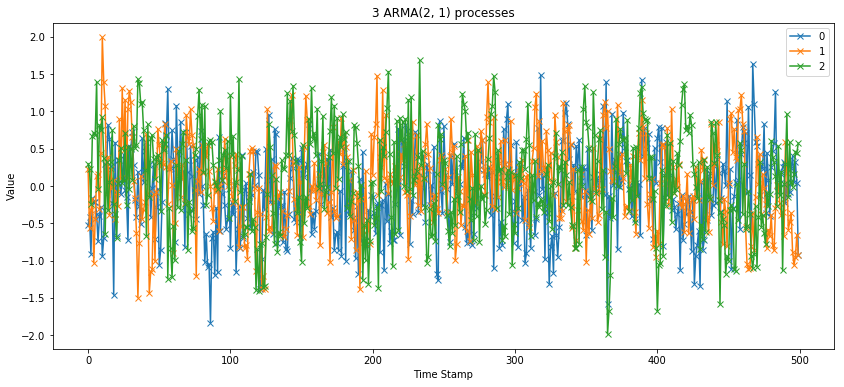

In [380]:
# generate 3 TS for each component model
n = 500
num = 10
X = []
E = []
cluster_ids = []
params_list = [(-0.05, 0.52, 0.44, sig), (0.36, 0.10, 0.06, sig), 
               (0.34, 0.27, -0.25, sig)]
for i, params in enumerate(params_list):
    for _ in range(num):
        x, e = arma_21(params, n)
        X.append(x)
        E.append(e)
        cluster_ids.append(i)


X = np.asarray(X)
E = np.asarray(E)

cluster_ids = np.asarray(cluster_ids)

idx = np.arange(X.shape[0])
np.random.shuffle(idx)

X = X[idx]
E = E[idx]
cluster_ids = cluster_ids[idx]

print("Shape of X: ", X.shape)
print("Shape of E: ", E.shape)
print("Cluster Ids of 30 processes: ", cluster_ids)

# plot 3 curves
plt.figure(figsize = (14, 6))
for i in range(3):
    plt.plot(X[i], "-x", label = i)
plt.xlabel("Time Stamp")
plt.ylabel("Value")
plt.title("3 ARMA(2, 1) processes")
plt.legend()
plt.show()

**********************
### EM Algorithm 
* Note that number of iterations (T) taken as 20

Number of clusters:  3
AR parameter p:  2
MA parameter q:  1
T : 0
Time taken : 0.0007140636444091797
--------
T : 10
Time taken : 7.946220397949219
--------


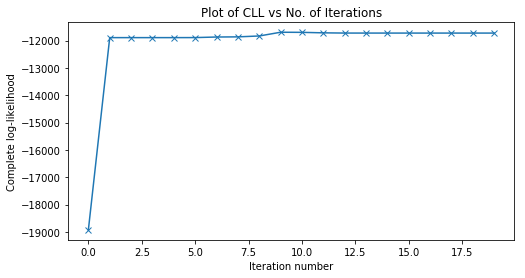

Cluster ID:  0
Parameters:  [ 0.00718277  0.53607277  0.18516333 -0.19309869]
Probability:  0.635188918337
Variance:  0.270136436915
-----------------
Cluster ID:  1
Parameters:  [ 0.01192223  0.50821121  0.45299662 -0.34618486]
Probability:  0.0333329764003
Variance:  0.287937634548
-----------------
Cluster ID:  2
Parameters:  [-0.00515673  0.46335053  0.25801813 -0.36043709]
Probability:  0.331478105263
Variance:  0.264410473268
-----------------


In [383]:
def EM_algo(K, p, q):
    
    print("Number of clusters: ", K)
    print("AR parameter p: ", p)
    print("MA parameter q: ", q)
    
    stime = time.time()
    
    T = 20

    pi = np.ones(K) / K
    var = np.ones(K)

    resp = np.empty([N, K])
    
    delta = np.random.rand(K, p+q+1)

    cll = []

    for _ in range(T):
        if (_ % 10 == 0): 
            print("T :", _)
            print("Time taken :", time.time() - stime)
            print("--------")

        # E-step
        temp = 0
        for i in range(N): 
            err = np.empty([n, K])
            for t in range(n):
                if t >= max(p,q) + 1: 
                    err[t] = X[i, t] - delta[:, 0] - delta[:, 1:p+1] @ X[i, t-1:t-p-1:-1] 
                            - delta[:, p+1:p+q+1] @ E[i, t-1:t-q-1:-1]
                else:  err[t] = X[i, t] - delta[:, 0]
            err = err.T
            exps = n/2 * np.log(2*np.pi*var) 
                + np.linalg.norm(err, axis = 1)**2 / (2*var)
            lognum = np.log(pi) - exps
            maxexp = np.max(lognum)
            sum1 = np.sum([np.exp(lognum-maxexp)])
            resp[i] = np.exp(lognum - maxexp  - np.log(sum1))

            # complete log likelihood -- for tracking
            temp += np.sum(resp[i] @ np.log(pi)) - np.sum(resp[i] @ exps)

        cll.append(temp)

        # M-step
        for k in range(K):
            N_k = np.sum(resp[:, k])
            pi[k] = N_k / N
            var[k] = np.linalg.norm(E, axis = 1)**2 
                    @ resp[:, k] / (n * np.sum(resp[:, k])) 

            U = np.zeros(p+q+1)
            W  = np.zeros((p+q+1, p+q+1))

            for i in range(N):
                A = np.zeros((p+1, p+1))
                B = np.zeros((p+1, q))
                C = np.zeros((q, p+1))
                D = np.zeros((q, q))
                a = np.zeros(p+1)
                c = np.zeros(q)

                A[0, 0] = n
                A[0, 1:] = np.asarray([np.sum(X[i, 0:n-v]) for v in range(1, p+1)])
                B[0, :] = np.asarray([np.sum(E[i, 0:n-v]) for v in range(1, q+1)])
                A[1:, 0] = np.asarray([np.sum(X[i, 0:n-v]) for v in range(1, p+1)])
                C[:, 0] = np.asarray([np.sum(E[i, 0:n-v]) for v in range(1, q+1)])

                for u in range(1, p+1):
                    for v in range(1, p+1):
                        if u <= v: A[u, v] = X[i, v-u:n-u] @ X[i, 0:n-v]
                        else: A[u, v] = X[i, 0:n-u] @ X[i, u-v:n-v]

                    for v in range(1, q+1):
                        if u <= v: B[u, v-1] = E[i, v-u:n-u] @ X[i, 0:n-v]
                        else: B[u, v-1] = E[i, 0:n-u] @ X[i, u-v:n-v]

                for u in range(1, q+1):
                    for v in range(1, p+1):
                        if u <= v: C[u-1, v] = X[i, v-u:n-u] @ E[i, 0:n-v]
                        else: C[u-1, v] = X[i, 0:n-u] @ E[i, u-v:n-v]

                    for v in range(1, q+1):
                        if u <= v: D[u-1, v-1] = E[i, v-u:n-u] @ E[i, 0:n-v]
                        else: D[u-1, v-1] = E[i, 0:n-u] @ E[i, u-v:n-v]

                a[0] = np.sum(X[i])

                for v in range(1, p+1):
                    a[v] = X[i, v:n] @ X[i, 0:n-v]

                for v in range(1, q+1):
                    c[v-1] = X[i, v:n] @ E[i, 0:n-v]

                U += resp[i, k]*np.hstack((a, c))

                w_1 = np.hstack((A, B))
                w_2 = np.hstack((C, D))
                W += resp[i, k]*np.vstack((w_1, w_2))

            delta[k] = np.linalg.inv(W) @ U

    plt.figure(figsize = (8, 4))
    plt.plot(range(T), cll, "-x")
    plt.ylabel("Complete log-likelihood")
    plt.xlabel("Iteration number")
    plt.title("Plot of CLL vs No. of Iterations")
    plt.show()
    
    for k in range(K):
        print("Cluster ID: ", k)
        print("Parameters: ", delta[k])
        print("Probability: ", pi[k])
        print("Variance: ", var[k])
        print("-----------------")
        
    new_ids = np.asarray([np.argmax(r) for r in resp])
        
    return delta, pi, var, new_ids

N = num*3
delta, pi, var, new_ids = EM_algo(3, 2, 1)

### Cluster Similarity <br>
* while accounting for exchangeability

In [384]:
# cluster similarity -- accounting for exchangeability
K = 3
max_sim = []
for i in range(K):
    t1 = np.where(new_ids == i)[0]
    max_sim.append(0)
    for j in range(K):
        t2 = np.where(cluster_ids == j)[0]
        sim = 2*np.intersect1d(t1, t2).shape[0] / (np.shape(t1)[0] + np.shape(t2)[0])
        if sim > max_sim[i]: max_sim[i] = sim

clus_sim = sum(max_sim) / K

print("Cluster Similarity: ", clus_sim)

Cluster Similarity:  0.6238244514106583


### Bayesian Information Critierion

In [385]:
# Bayesian Information Criterion

K = 3
p = 2
q = 1
param_bic = (K*(p+q+1) + K + K- 1)*np.log(n*N)

ll_bic = 0
for i in range(N):
    d = delta[new_ids[i]]
    v = var[new_ids[i]]
    err = np.empty(n)
    for t in range(n):
        if t >= max(p,q) + 1: 
            err[t] = X[i, t] - d[0] - d[1:p+1] @ X[i, t-1:t-p-1:-1] 
                    - d[p+1:p+q+1] @ E[i, t-1:t-q-1:-1]
        else:  err[t] = X[i, t] - d[0]
    
    ll_bic -= n/2 * np.log(2*np.pi*v) + np.linalg.norm(err)**2 / (2*v)

bic = 2*ll_bic - param_bic

print("Bayesian Information Criterion with K, p, q : ", [K, p, q], "is ", bic)

Bayesian Information Criterion with K, p, q :  [3, 2, 1] is  -23567.0951637


*******************
### Experiments
* Try different values of K, p, q and see which one works better using BIC

In [ ]:
K_vals = [1, 2, 3, 4, 5]
pq_vals = [(1, 1), (1, 2), (2, 1), (3, 1), (4, 1)]

bic = []

for K in K_vals:
    for (p, q) in pq_vals:
        
        param_bic = (K*(p+q+1) + K + K- 1)*np.log(n*N)

        ll_bic = 0
        delta, pi, var, new_ids = EM_algo(K, p, q)
        
        for i in range(N):
            d = delta[new_ids[i]]
            v = var[new_ids[i]]
            err = np.empty(n)
            for t in range(n):
                if t >= max(p,q) + 1: 
                    err[t] = X[i, t] - d[0] - d[1:p+1] @ X[i, t-1:t-p-1:-1] 
                    - d[p+1:p+q+1] @ E[i, t-1:t-q-1:-1]
                else:  err[t] = X[i, t] - d[0]

            ll_bic -= n/2 * np.log(2*np.pi*v) + np.linalg.norm(err)**2 / (2*v)

        bic.append(2*ll_bic - param_bic)

        print("Bayesian Information Criterion with K, p, q : ", [K, p, q], "is ", bic[-1])
        print("****************************************************************")

In [366]:
bic_norm = (bic - min(bic))
bic_norm = bic_norm / max(bic_norm)

bic_norm

array([ 0.27383783,  0.        ,  0.61050917,  0.71063051,  0.70347159,
        0.57297075,  0.20764925,  0.95114377,  1.        ,  0.98725254,
        0.52299774,  0.14770012,  0.91758181,  0.98996471,  0.90732037,
        0.40846709,  0.087751  ,  0.83125219,  0.85980297,  0.82738821,
        0.45894073,  0.02780187,  0.79863557,  0.79017958,  0.74745604])

In [367]:
bic_norm = np.asarray(bic_norm)
bic_norm = np.reshape(bic_norm, [len(K_vals), len(pq_vals)])

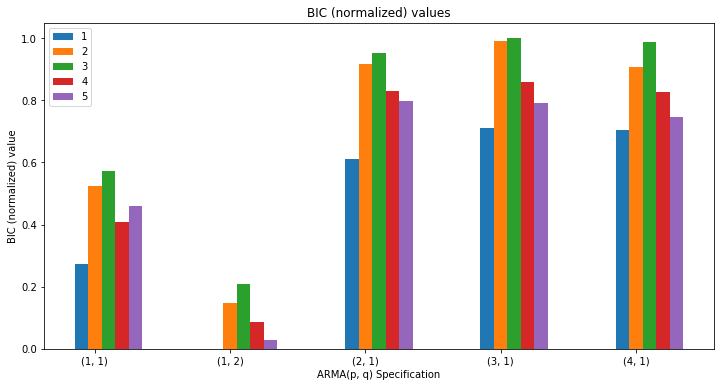

In [374]:
idx = np.arange(5)
width = 0.1
plt.figure(figsize = (12, 6))
for i, bn in enumerate(bic_norm):
    plt.bar(idx + i*width, bn, width, label = i + 1)
plt.xticks(idx + width, ('(1, 1)', '(1, 2)', '(2, 1)', '(3, 1)', '(4, 1)'))
plt.xlabel("ARMA(p, q) Specification")
plt.ylabel("BIC (normalized) value")
plt.title("BIC (normalized) values")
plt.legend()
plt.show()

* From the above graph, we can see that for K = 3, the BIC values are higher. This holds good with the fact that 
our data has been generated from 3 ARMA models.

* While (3, 1) and (4, 1) seem to be on the higher end of BIC values, it can be attributed to overfitting (ie, larger
number of parameters). Note that (2, 1) has almost comparable values as that of (3, 1) showing the efficacy of our work. 

* Some ways to improve our current work -- better initializations, and stochastic EM algorithm

************************************************************